In [1]:
using Revise, Plots, FFTW, LinearAlgebra, LaTeXStrings, Random, Distributions

In [2]:
includet("../../src/SparseSpikes.jl")
using .SparseSpikes

Define ground truth amplitudes and positions

In [3]:
# Define the number of Fourier coefficients
fc = 6
n = 2fc + 1

# Define noise level
noise_level = 0

# Seed for noise
Random.seed!(12)

TaskLocalRNG()

In [4]:
domain = [0, 1]

# Seperation
Δ = 0.2/fc

x0 = [0.5-.5Δ, 0.5+.5Δ]
a0 = [1.0, 1.0]

μ0 = DiscreteMeasure(x0, a0)

DiscreteMeasure([0.48333333333333334, 0.5166666666666667], [1.0, 1.0], 1, 2)

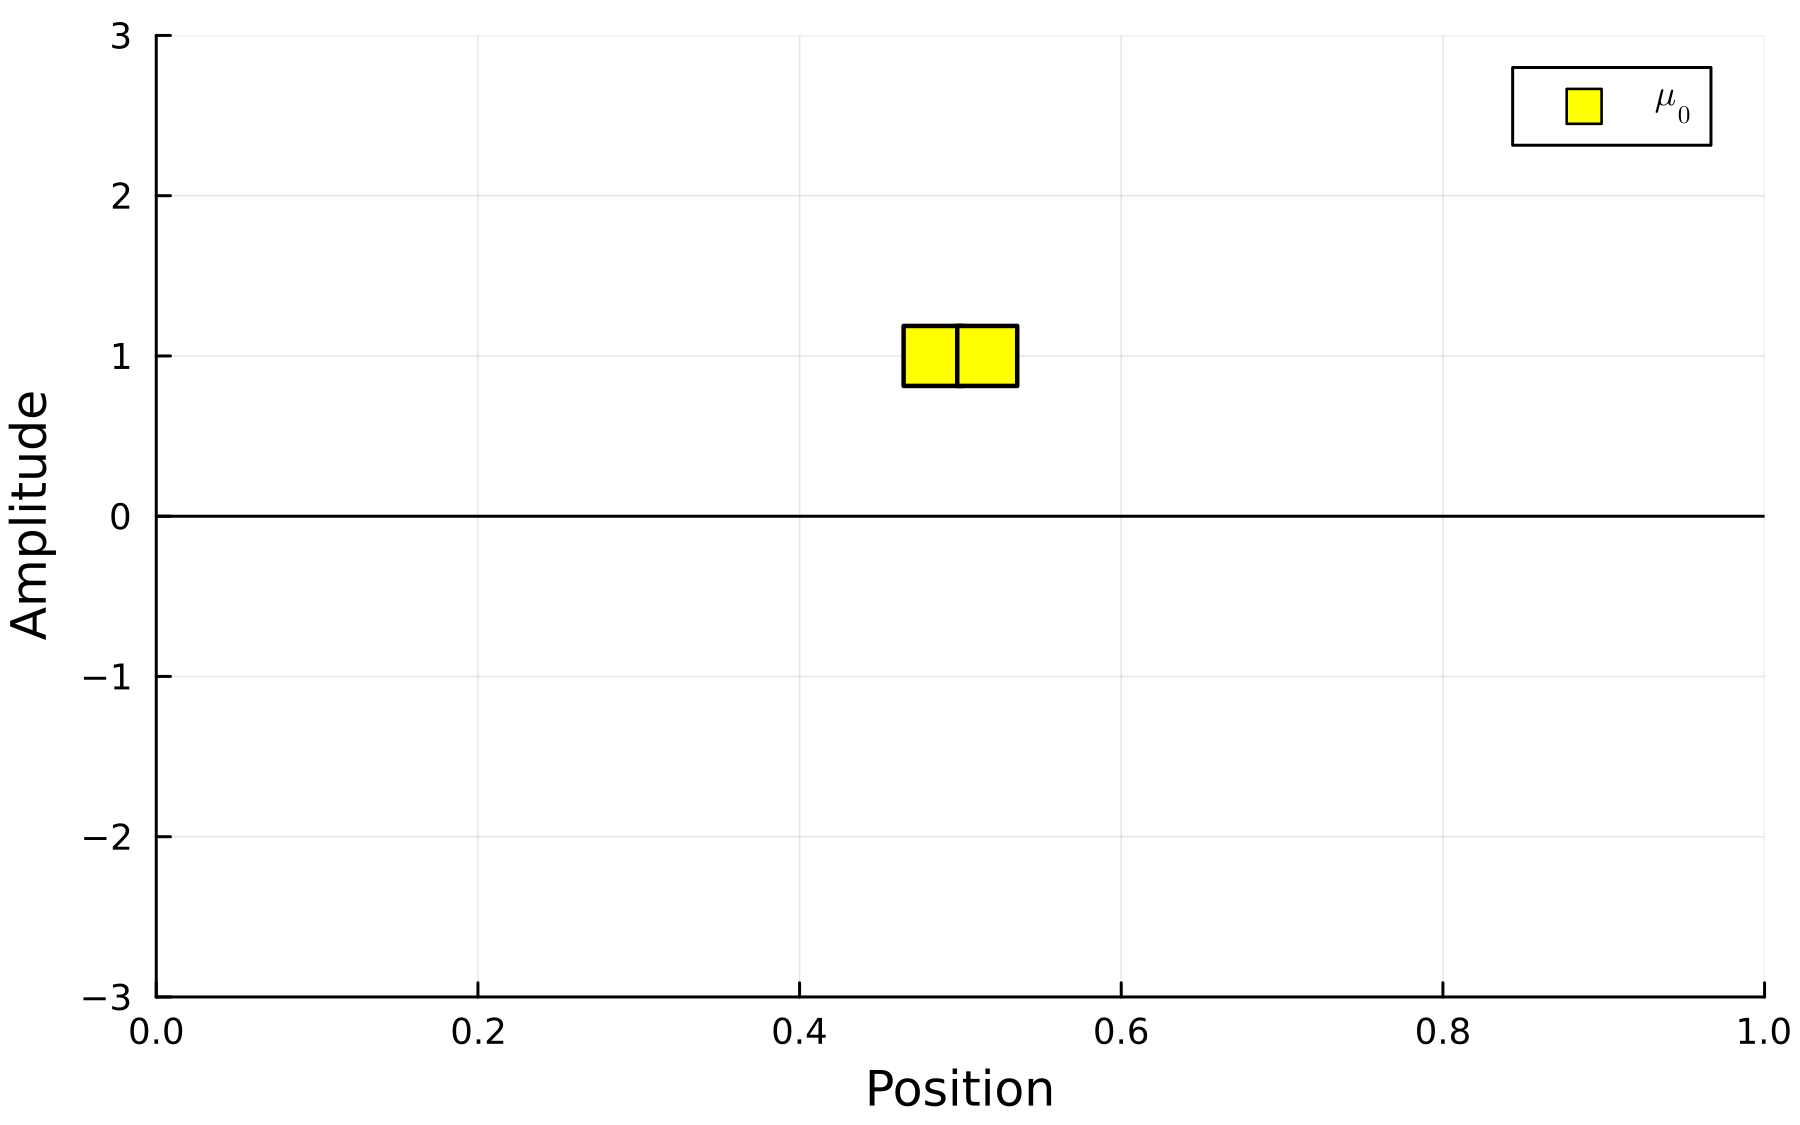

In [5]:
# Define the plot
num_points = 1000
plt_grid = range(domain..., length=(num_points + 1))
plot_size = (400, 250) .* 1.5
plt = plot(xlims=extrema(domain), ylims=(-3, 3), xlabel="Position", ylabel="Amplitude", legend=:topright, size=plot_size, dpi=300)
hline!(plt, [0], linestyle=:solid, color=:black, label="")

plot!(plt, μ0.x, μ0.a, seriestype=:scatter, color=:yellow, label=L"μ_0", marker=:square, markersize=10, markerstrokewidth=2)

In [6]:
ops = fourier_operators_1D(fc, plt_grid)

Operators(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.2773500981126146, -6:6), var"#Φ#13"{var"#ϕ#12"{Float64, UnitRange{Int64}}}(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.2773500981126146, -6:6)), var"#adjΦ#14"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, UnitRange{Int64}}}}(0.0:0.001:1.0, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, UnitRange{Int64}}}(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.2773500981126146, -6:6))))

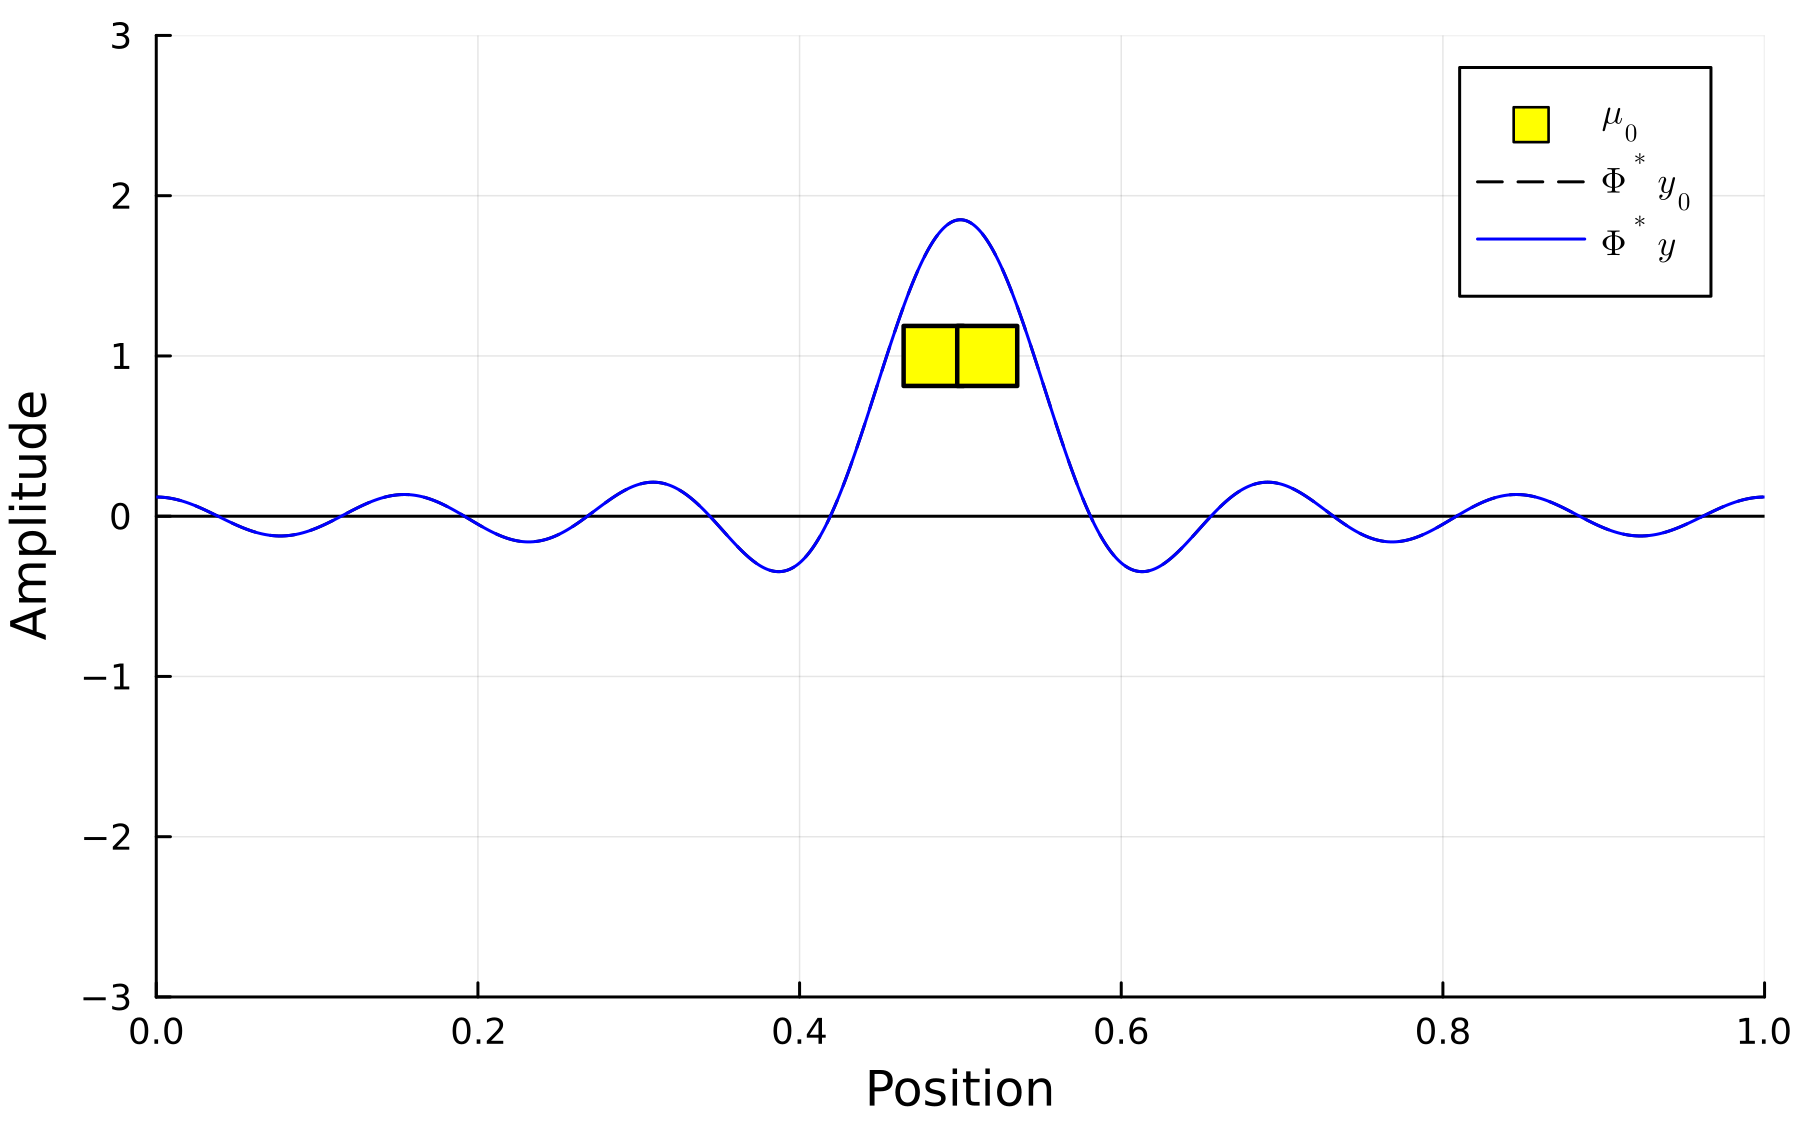

In [7]:
# Calculate the observation y0 = Φμ0
y0 = ops.Φ(x0, a0)

# Add noise to the observation y = y0 + w
sigma = noise_level * norm(y0)
w = fftshift(fft(randn(length(y0))))
w = w / norm(w) * sigma
y = y0 + w

plt_obs = deepcopy(plt)

plot!(plt_obs, plt_grid, ops.adjΦ(y0), label=L"Φ^*y_0", color=:black, linestyle=:dash)
plot!(plt_obs, plt_grid, ops.adjΦ(y), label=L"Φ^*y", color=:blue)

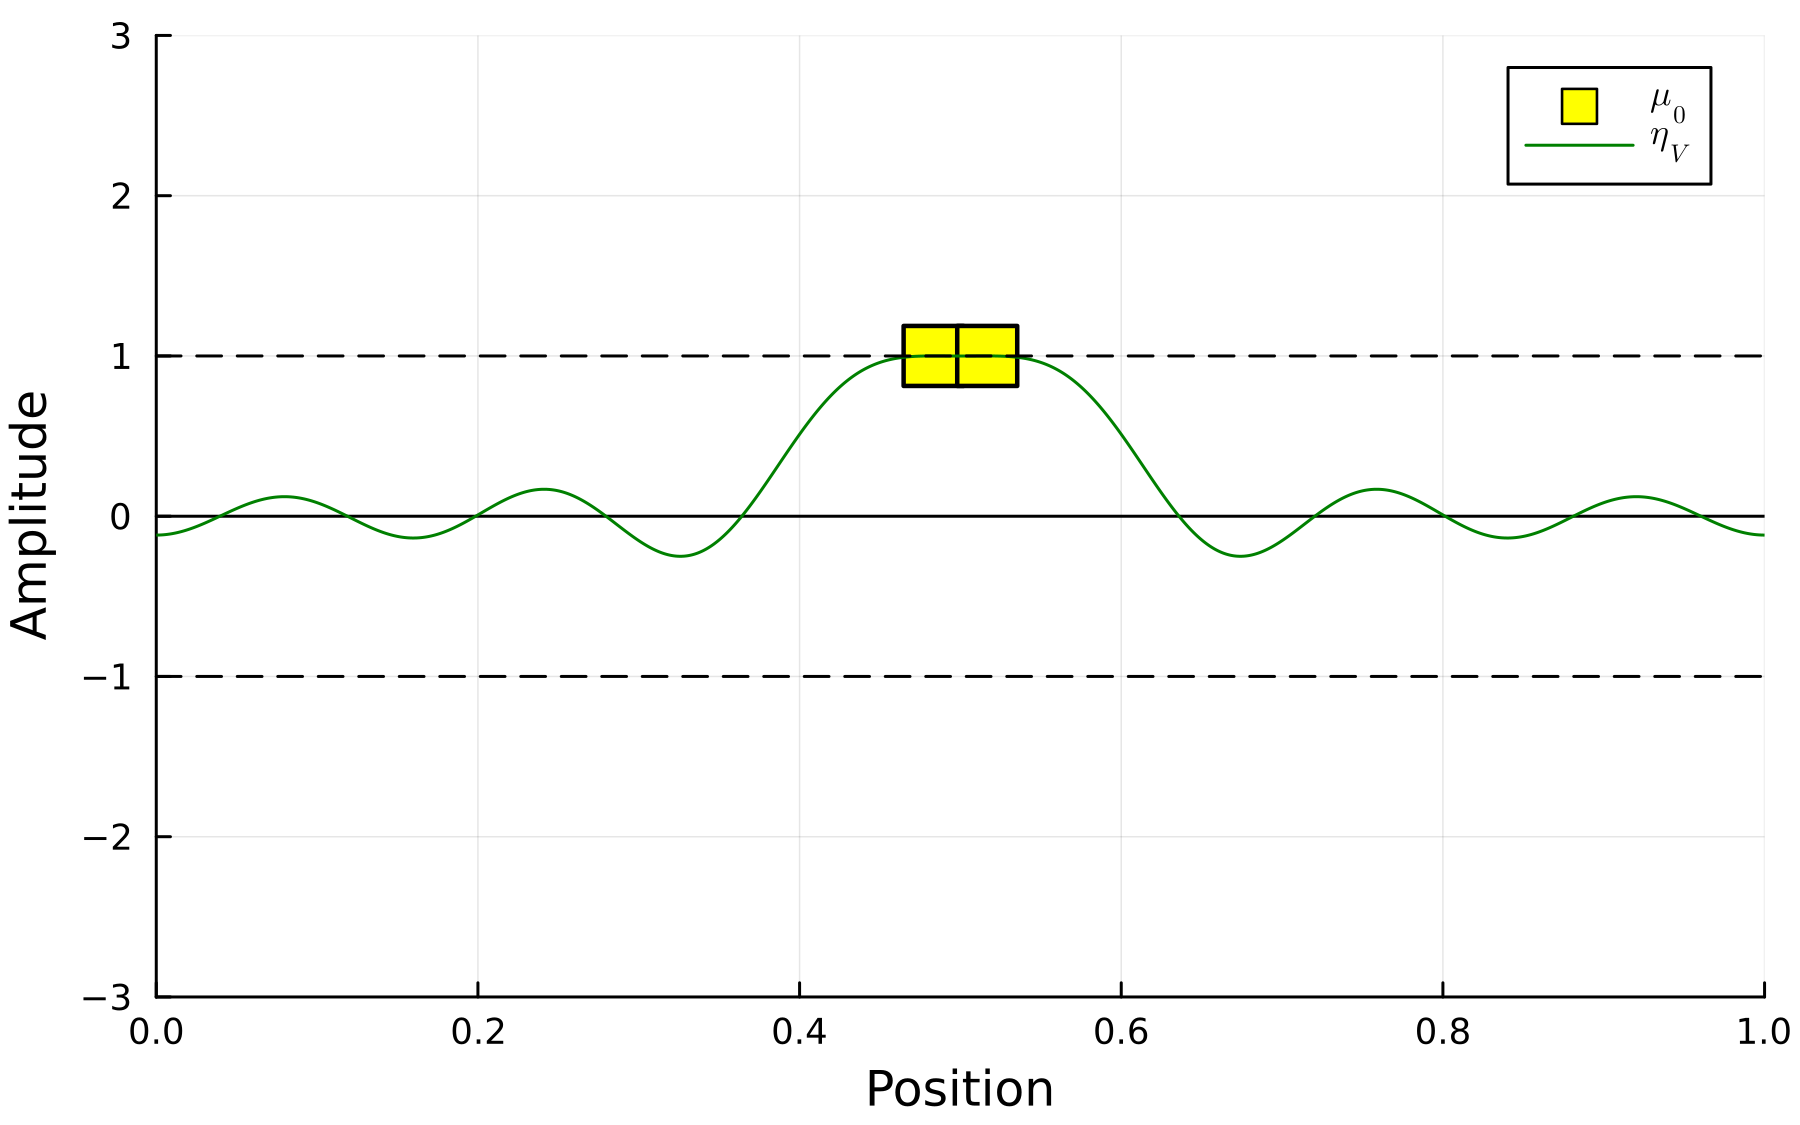

In [8]:
ηV = pre_certificate(μ0, ops)

plt_cert = deepcopy(plt)

plot!(plt_cert, plt_grid, ηV, label=L"η_V", color=:green)
hline!(plt_cert, [1, -1], linestyle=:dash, color=:black, label="")

## SDP

In [9]:
λ = 0

prob = BLASSO(y, ops, domain, λ)

prob_sdp = deepcopy(prob)

solve!(prob_sdp, :SDP)

Problem
  Name                   :                 
  Objective sense        : maximize        
  Type                   : CONIC (conic optimization problem)
  Constraints            : 262             
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 26              
  Matrix variables       : 1 (scalarized: 406)
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - primal attempts        : 1                 successes              : 1               
Lin. dep.  - dual attempts          : 0        

BLASSO(ComplexF64[0.4487618855293279 + 4.718447854656915e-16im, -0.4803844614152611 - 5.551115123125783e-16im, 0.5067438446150173 - 2.636779683484747e-16im, -0.5275512362102044 - 2.636779683484747e-16im, 0.5425786660642791 - 1.3877787807814457e-16im, -0.551661490511068 + 6.591949208711867e-17im, 0.5547001962252291 + 0.0im, -0.551661490511068 - 6.591949208711867e-17im, 0.5425786660642791 + 1.3877787807814457e-16im, -0.5275512362102044 + 2.636779683484747e-16im, 0.5067438446150173 + 2.636779683484747e-16im, -0.4803844614152611 + 5.551115123125783e-16im, 0.4487618855293279 - 4.718447854656915e-16im], Operators(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.2773500981126146, -6:6), var"#Φ#13"{var"#ϕ#12"{Float64, UnitRange{Int64}}}(var"#ϕ#12"{Float64, UnitRange{Int64}}(0.2773500981126146, -6:6)), var"#adjΦ#14"{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, var"#adjΦ#11#15"{var"#ϕ#12"{Float64, UnitRange{Int64}}}}(0.0:0.001:1.0, var"#adjΦ#11#15"{var"#ϕ#12"{

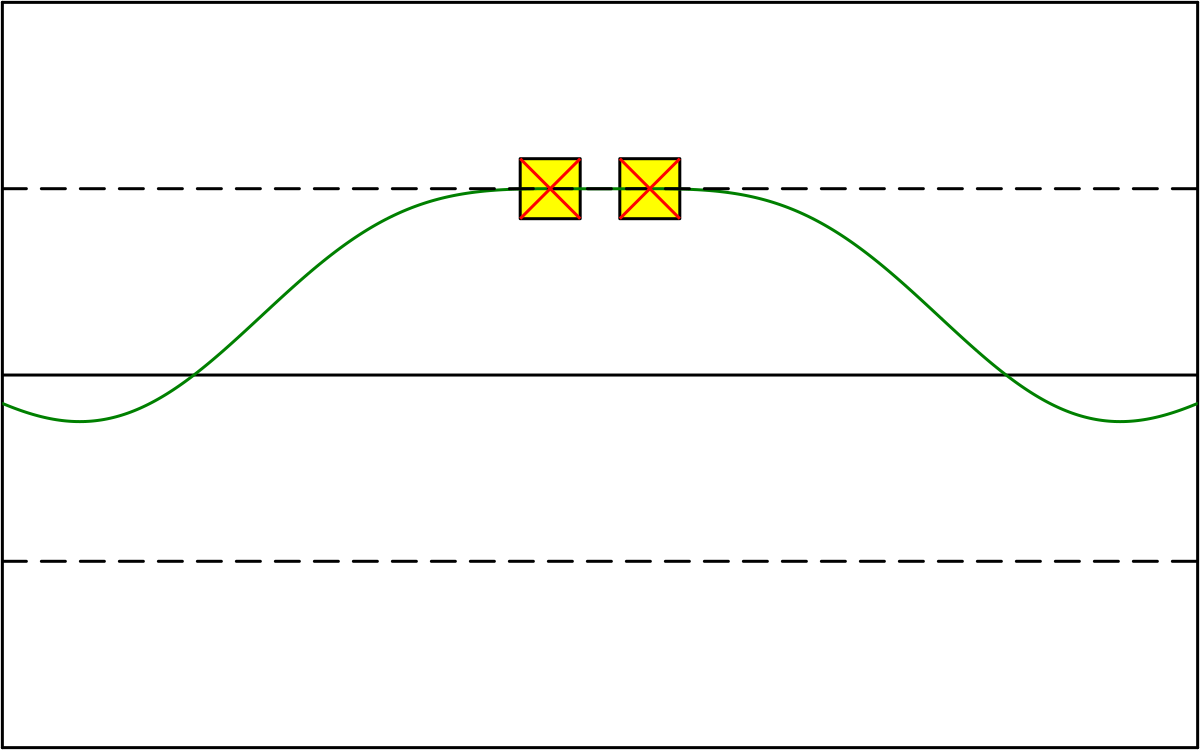

In [19]:
plt_sdp = deepcopy(plt_cert)

# dual polynomial
ηλ = ops.adjΦ(prob_sdp.p) * sqrt(n)
# plot!(plt_sdp, plt_grid, ηλ, label=L"η_λ", color=:purple)
# hline!(plt_sdp, [1, -1], linestyle=:dash, color=:black, label="")
plot!(plt_sdp, prob_sdp.μ.x, prob_sdp.μ.a, seriestype=:scatter, color=:red, label=L"μ_λ", marker=:x, markersize=10, markerstrokewidth=2)

using Plots.Measures
plot!(
    xlabel="", ylabel="", legend=:none, legendfontsize=12,
    ticks=false, frame=:box,
    xlims=(0.3, 0.7), ylims=(-2,2), margins=-1.8mm,
    size=plot_size ./1.5)

In [20]:
savefig(plt_sdp, "../../figures/1D/ClosePositive.svg")

"c:\\Users\\ladis\\OneDrive - University of Warwick\\Year 4\\Super resolution\\Codes\\SparseSpikes\\figures\\1D\\ClosePositive.svg"

In [12]:
# savefig(plt_sfw, "../figures/SDPandSFW.svg")